# Gather Data using APIs

In [ ]:
# data 
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN 

In [ ]:
!pip install yfinance # uncomment it to download

In [ ]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

In [3]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2019-01-01'
end_period = '2021-01-01'

In [7]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [8]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.326290,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.508713,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.981861,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.901772,219111200


In [ ]:
data.tail(12)

## including all weekdays in the data

## Your TASK01 (after the code walk through)
> incorporate the logic below to re-build your model

In [ ]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [ ]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [10]:
df = pd.DataFrame(data.Close)
# get rownames as columns
df.index.name = 'Date'
df.reset_index(inplace=True)

In [11]:
df.head()

,Date,Close
0,2019-01-02,39.480000
1,2019-01-03,35.547501
2,2019-01-04,37.064999
3,2019-01-07,36.982498
4,2019-01-08,37.687500


In [ ]:
print(df.columns)
print(df.dtypes)
print(df.describe)

In [ ]:
df.tail(12)

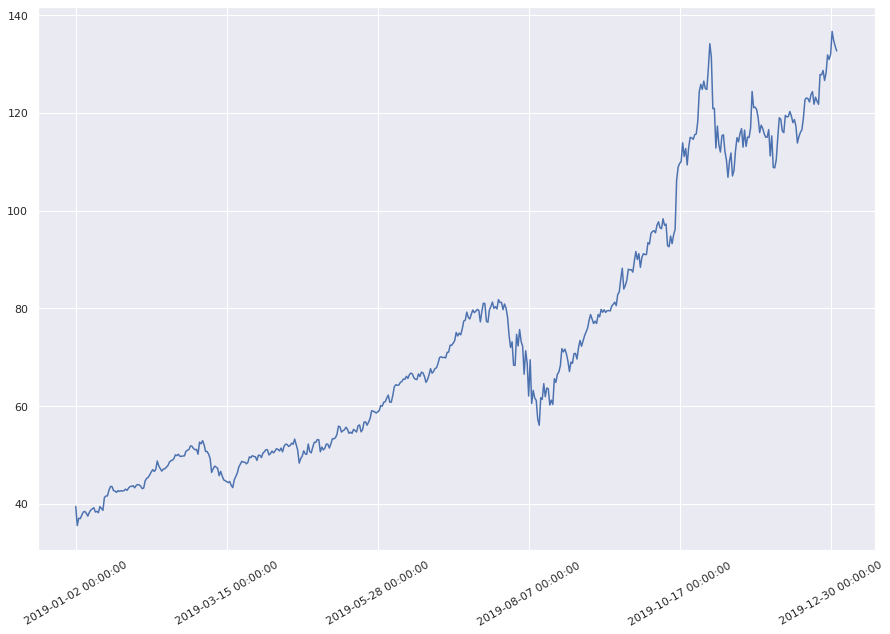

In [12]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)
plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')

plt.show()

# Data Prep

In [ ]:
print(type(df['Close']))
print(type(df[['Close']]))
print(type(df.Close))
print(type(df.Close.values))

In [13]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))

In [14]:
df.Close_norm.shape

(505,)

In [15]:
505 -12

493

In [16]:
def train_test_prep(series, window_size, test_prop=0.3): 
  # series should be a numpy series
  series = series.to_numpy()
  # print(type(series))
  data = []
  for i in range(len(series) - window_size):
    data.append(series[i: i+window_size])
  data = np.array(data)

  test_size = int(np.round(test_prop* data.shape[0]))
  
  train_size = data.shape[0] - test_size
  print('train size is', train_size)
  print('test size is', test_size)

  train_x = data[:train_size, :-1]
  train_y = data[:train_size, -1]

  test_x = data[train_size:, :-1]
  test_y = data[train_size:, -1]

  return [train_x, train_y, test_x, test_y]

In [17]:
ws = 12

x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train size is 345
test size is 148
train_x (345, 11, 1)
train_y (345, 1)
test_x (148, 11, 1)
test_y (148, 1)


In [ ]:
# data.Close[:25]

In [ ]:
y_train[:5]

In [ ]:
print(x_train[:3])

In [18]:
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [19]:
print(x_train[:3]) # now it is a tensor 

tensor([[[-0.9222],
         [-1.0000],
         [-0.9700],
         [-0.9716],
         [-0.9577],
         [-0.9450],
         [-0.9426],
         [-0.9501],
         [-0.9614],
         [-0.9462],
         [-0.9370]],

        [[-1.0000],
         [-0.9700],
         [-0.9716],
         [-0.9577],
         [-0.9450],
         [-0.9426],
         [-0.9501],
         [-0.9614],
         [-0.9462],
         [-0.9370],
         [-0.9324]],

        [[-0.9700],
         [-0.9716],
         [-0.9577],
         [-0.9450],
         [-0.9426],
         [-0.9501],
         [-0.9614],
         [-0.9462],
         [-0.9370],
         [-0.9324],
         [-0.9277]]])


The inputs are stored as a 3D tensor with dim as  **[number of
sequences, length of the series, number of features]**. 
> As we are using a univariate time series for forecasting future values, the number of features is 1.

In [20]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x torch.Size([345, 11, 1])
train_y torch.Size([345, 1])
test_x torch.Size([148, 11, 1])
test_y torch.Size([148, 1])


# Vanilla RNN


In [21]:
seed = 1234
torch.manual_seed(seed)

In [22]:
# hyperparams
input_dim = 1 # The number of expected features in the input x

hidden_dim = 100 #  The number of features in the hidden state h

num_layers = 1 # Number of recurrent layers. (default: 1)

# out_dim = 1
learning_rate = 0.01
epochs = 100

### Arcitechure

In [23]:
# define RNN
class RNN(nn.Module):
  def __init__(self, input_size=1, hidden_size=100):
    super().__init__()
    self.hidden_size = hidden_size
    
    self.rnn = nn.RNN(input_size, # expected features
                      hidden_size, 
                      batch_first = True) #(N, L, Hin)

    self.fc1 = nn.Linear(hidden_size, 1) # outputing 1 value at the end using final hidden state

  def forward(self, x):
    # inputs shape: (batch size, seq length, num features) (N, L, Hin); 
    # output shape: (N, L,D∗Hout) [for us it is (N, L =11, 100) since D =1 (uni-directional), Hout= 100]
    print('input shape', x.shape) 
    
    h0 = torch.zeros(1, x.size(0), self.hidden_size) # (1, N, Hout)
    print('hidden shape', h0.shape)
    out, self.hidden =  self.rnn(x, h0.detach()) # detach as a solution for vanishing gradients. Truncated BPTT
    print('intermediate out shape', out.shape)

    out = self.fc1(out[:, -1,:]) # pass the last out state through linear layer to get final output
    # print(out.shape)
    print('final out shape: ', out.shape)
    return out

### Instantiate your Model

In [24]:
# initialize model
model = RNN()
# loss
loss_function = nn.MSELoss(reduction='mean')

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
# x = torch.randn(1,8)
# make_dot(model(x_train), params=dict(model.named_parameters()))

In [25]:
next(model.parameters()).is_cuda

False

In [ ]:
# asdf

### Define Learning flow

In [26]:
import time

losses = np.zeros(epochs)
start = time.time()
rnn = []

for epoch in range(epochs):
  optimizer.zero_grad()
  # model.hidden = torch.zeros(1,x_train.size(0),model.hidden_size).cuda()
  y_train_pred = model(x_train)

  loss = loss_function(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item() # document loss for each epoch
  loss.backward() # back propagation
  optimizer.step() # adjust the weights

print('training took: ', time.time() - start)


input shape torch.Size([345, 11, 1])
hidden shape torch.Size([1, 345, 100])
intermediate out shape torch.Size([345, 11, 100])
final out shape:  torch.Size([345, 1])
Epoch number:  0 Error:  0.3110208213329315
input shape torch.Size([345, 11, 1])
hidden shape torch.Size([1, 345, 100])
intermediate out shape torch.Size([345, 11, 100])
final out shape:  torch.Size([345, 1])
Epoch number:  1 Error:  0.2724553048610687
input shape torch.Size([345, 11, 1])
hidden shape torch.Size([1, 345, 100])
intermediate out shape torch.Size([345, 11, 100])
final out shape:  torch.Size([345, 1])
Epoch number:  2 Error:  0.23938509821891785
input shape torch.Size([345, 11, 1])
hidden shape torch.Size([1, 345, 100])
intermediate out shape torch.Size([345, 11, 100])
final out shape:  torch.Size([345, 1])
Epoch number:  3 Error:  0.21093517541885376
input shape torch.Size([345, 11, 1])
hidden shape torch.Size([1, 345, 100])
intermediate out shape torch.Size([345, 11, 100])
final out shape:  torch.Size([345, 1

In [27]:
hist = losses

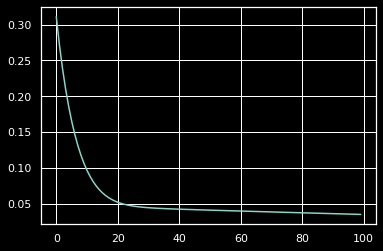

In [28]:
# plt.figure(figsize = (8, 8))
plt.style.use("dark_background") # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.plot(losses)
plt.xlabel = 'epochs'
plt.ylabel = 'loss values'
plt.show()

In [29]:
predictions = y_train_pred.detach().cpu()
predictions = scale.inverse_transform(np.array(predictions).reshape(-1, 1))
predict = pd.DataFrame(predictions)
predict.head(4)

,0
0,53.949646
1,54.013325
2,54.068340
3,53.962193


In [30]:
len(predict)

345

In [31]:
y_train= y_train.detach().cpu()
original = scale.inverse_transform(np.array(y_train).reshape(-1, 1))
original = pd.DataFrame(original)
original.head(4)

,0
0,38.965000
1,39.205002
2,38.325001
3,38.479996


In [32]:
len(original)

345

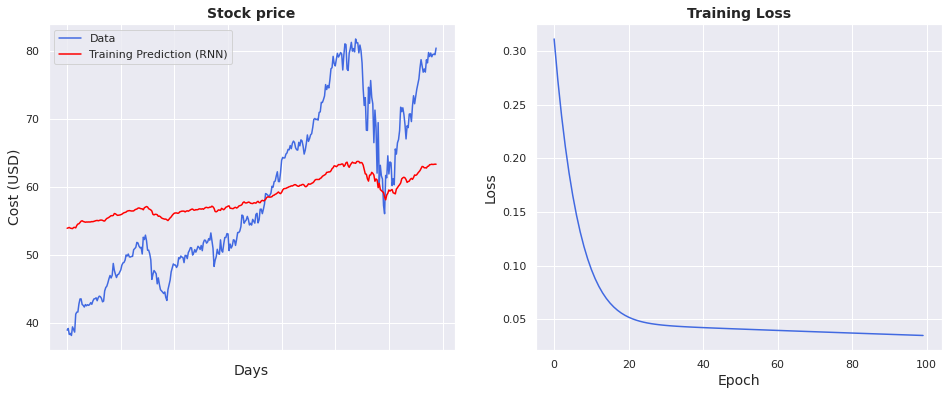

In [33]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [34]:
import math, time
from sklearn.metrics import mean_squared_error
model.eval() # put the model in evaluation mode before testing

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train)
y_test_pred = scale.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


input shape torch.Size([148, 11, 1])
hidden shape torch.Size([1, 148, 100])
intermediate out shape torch.Size([148, 11, 100])
final out shape:  torch.Size([148, 1])
Train Score: 9.46 RMSE
Test Score: 41.35 RMSE


In [ ]:
# Train Score: 3.31 RMSE # AAPL 
# Test Score: 3.29 RMSE

In [35]:
# future prediction
x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws, test_prop=0.0)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

train size is 493
test size is 0
train_x (493, 11, 1)
train_y (493, 1)
test_x (0, 11, 1)
test_y (0, 1)


In [36]:
# re-train the whole model
# set model to back to training mode
model.train()
import time

losses = np.zeros(epochs)
start = time.time()
rnn = []

for epoch in range(epochs):
  optimizer.zero_grad()
  # model.hidden = torch.zeros(1,1,model.hidden_size).cuda()
  y_train_pred = model(x_train)

  loss = loss_function(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item()
  loss.backward()
  optimizer.step()

print('training took: ', time.time() - start)


input shape torch.Size([493, 11, 1])
hidden shape torch.Size([1, 493, 100])
intermediate out shape torch.Size([493, 11, 100])
final out shape:  torch.Size([493, 1])
Epoch number:  0 Error:  0.2250981628894806
input shape torch.Size([493, 11, 1])
hidden shape torch.Size([1, 493, 100])
intermediate out shape torch.Size([493, 11, 100])
final out shape:  torch.Size([493, 1])
Epoch number:  1 Error:  0.21204379200935364
input shape torch.Size([493, 11, 1])
hidden shape torch.Size([1, 493, 100])
intermediate out shape torch.Size([493, 11, 100])
final out shape:  torch.Size([493, 1])
Epoch number:  2 Error:  0.20120874047279358
input shape torch.Size([493, 11, 1])
hidden shape torch.Size([1, 493, 100])
intermediate out shape torch.Size([493, 11, 100])
final out shape:  torch.Size([493, 1])
Epoch number:  3 Error:  0.1920573115348816
input shape torch.Size([493, 11, 1])
hidden shape torch.Size([1, 493, 100])
intermediate out shape torch.Size([493, 11, 100])
final out shape:  torch.Size([493, 1

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

In [ ]:
x_train.shape

In [ ]:
feed = y_train[-11:].view(1,11,1)

In [ ]:
# last = x_train[-1:].cpu().numpy()
last = feed.cpu().numpy()

In [ ]:
last

In [ ]:
last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,11, 1)
last_tensor

In [ ]:
df['Close_norm'].iloc[-11:].values

In [37]:
# feed = y_train[-11:].view(1,11,1)# reshape it to suit the input shape of 1,11,1
feed = torch.from_numpy(df['Close_norm'].iloc[-ws:].values).type(torch.Tensor).view(-1,ws, 1)

last = feed.cpu().numpy()
new_predictions = []
model.eval()
# make predictions
for i in range(12):
  print('before', last)
  last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,ws, 1)
  pred = model(last_tensor)
  new_predictions.append(pred.item())
  newpred = pred.cpu().detach().numpy()
  last = np.append(last, newpred)[-ws:]
  # print('after', last)


before [[[0.8257902 ]
  [0.8244061 ]
  [0.842005  ]
  [0.801666  ]
  [0.83271116]
  [0.9048867 ]
  [0.8866946 ]
  [0.90666634]
  [1.        ]
  [0.964011  ]
  [0.94127095]
  [0.9209037 ]]]
input shape torch.Size([1, 12, 1])
hidden shape torch.Size([1, 1, 100])
intermediate out shape torch.Size([1, 12, 100])
final out shape:  torch.Size([1, 1])
before [0.8244061  0.842005   0.801666   0.83271116 0.9048867  0.8866946
 0.90666634 1.         0.964011   0.94127095 0.9209037  0.87447757]
input shape torch.Size([1, 12, 1])
hidden shape torch.Size([1, 1, 100])
intermediate out shape torch.Size([1, 12, 100])
final out shape:  torch.Size([1, 1])
before [0.842005   0.801666   0.83271116 0.9048867  0.8866946  0.90666634
 1.         0.964011   0.94127095 0.9209037  0.87447757 0.8532262 ]
input shape torch.Size([1, 12, 1])
hidden shape torch.Size([1, 1, 100])
intermediate out shape torch.Size([1, 12, 100])
final out shape:  torch.Size([1, 1])
before [0.801666   0.83271116 0.9048867  0.8866946  0.906

In [38]:
unscale_new_predictions = scale.inverse_transform(np.array(new_predictions).reshape(-1, 1))
unscale_new_predictions

array([[130.3421759 ],
       [129.26746701],
       [128.25067452],
       [127.32091338],
       [126.45307462],
       [125.63295194],
       [124.85940895],
       [124.13379906],
       [123.44788123],
       [122.79673917],
       [122.18038493],
       [121.59496626]])

In [ ]:
df.Close[-12:]

# Your TASK-02 (visually inspect the future values with the predicted values)

> download stock close values for next 20 days (start="2021-01-01", end="2021-01-21") call it '**wht**' below<br/>
> plot **wht** values on the graph given on top of predicted values shown in blue color

In [ ]:
wht =  # write your code here

In [ ]:
[x for x in range(12,24)]
fig = plt.figure(figsize=(12,4))
plt.ylim([100, 140])
plt.plot([x for x in range(12)], df.Close[-12:], color = 'red')
plt.plot([x for x in range(12,24)], unscale_new_predictions, color='blue')

plt.show()